In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import talib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [149]:
warnings.filterwarnings("ignore")
data = yf.download("HBLPOWER.BO", start="2016-01-01", end="2025-01-30")
print(data.head)
print(data.shape)
data.sort_index(inplace=True)
print(data[-10:])

[*********************100%***********************]  1 of 1 completed

<bound method NDFrame.head of Price            Close        High         Low        Open      Volume
Ticker     HBLPOWER.BO HBLPOWER.BO HBLPOWER.BO HBLPOWER.BO HBLPOWER.BO
Date                                                                  
2016-01-01   42.170464   43.004606   41.336321   42.170464      178073
2016-01-04   40.363163   42.170470   39.482680   42.170470      165062
2016-01-05   42.680218   43.746066   40.455844   40.548525      543677
2016-01-06   41.938766   43.977779   41.011943   43.421683      211112
2016-01-07   39.250969   41.475346   38.833901   41.475346      149397
...                ...         ...         ...         ...         ...
2025-01-23  545.200012  552.900024  540.200012  540.200012       64908
2025-01-24  529.900024  551.150024  527.450012  541.750000       51106
2025-01-27  501.399994  526.500000  496.799988  511.600006      242170
2025-01-28  512.849976  535.799988  473.000000  504.049988      261240
2025-01-29  544.500000  547.500000  517.299988 

In [150]:
data['LogVolume']=np.log(data['Volume'].replace(0,np.nan))
data.drop(columns='Volume', inplace=True)
data.dropna(axis=0, how='all')


Price,Close,High,Low,Open,LogVolume
Ticker,HBLPOWER.BO,HBLPOWER.BO,HBLPOWER.BO,HBLPOWER.BO,
Date,,,,,
2016-01-01,42.170464,43.004606,41.336321,42.170464,12.089949
2016-01-04,40.363163,42.170470,39.482680,42.170470,12.014076
2016-01-05,42.680218,43.746066,40.455844,40.548525,13.206111
2016-01-06,41.938766,43.977779,41.011943,43.421683,12.260144
2016-01-07,39.250969,41.475346,38.833901,41.475346,11.914362
...,...,...,...,...,...
2025-01-23,545.200012,552.900024,540.200012,540.200012,11.080726
2025-01-24,529.900024,551.150024,527.450012,541.750000,10.841657


In [151]:
# Check for NaN values in LogVolume and get the indices
nan_indices = data[data['LogVolume'].isnull()].index

# Drop the rows where LogVolume is NaN
data = data.drop(nan_indices)

# Optionally, you can reset the index after dropping the rows if needed
data = data.reset_index(drop=True)
data.isnull().sum()

Price      Ticker     
Close      HBLPOWER.BO    0
High       HBLPOWER.BO    0
Low        HBLPOWER.BO    0
Open       HBLPOWER.BO    0
LogVolume                 0
dtype: int64

In [152]:
scaler=MinMaxScaler()
scaled_values=scaler.fit_transform(data[data.columns])
df=pd.DataFrame(scaled_values, columns=data.columns, index=data.index)
df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Close, HBLPOWER.BO)  2217 non-null   float64
 1   (High, HBLPOWER.BO)   2217 non-null   float64
 2   (Low, HBLPOWER.BO)    2217 non-null   float64
 3   (Open, HBLPOWER.BO)   2217 non-null   float64
 4   (LogVolume, )         2217 non-null   float64
dtypes: float64(5)
memory usage: 86.7 KB
None


(438, 30, 5)


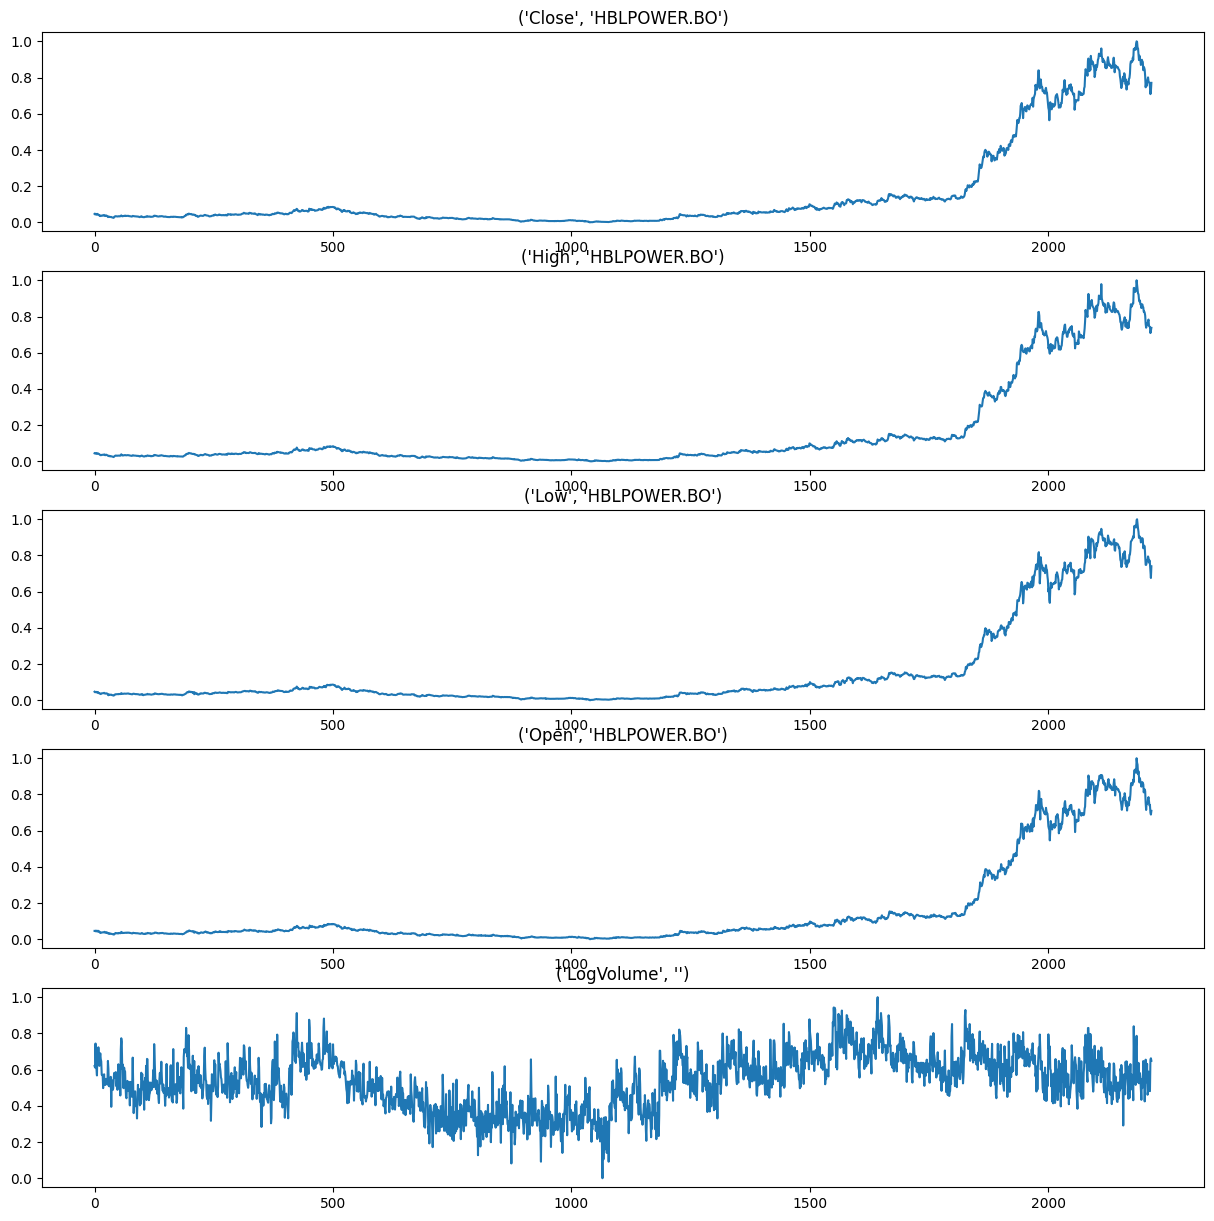

In [153]:

#plotting
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(5)

for ax, col in zip(axes, df.columns):
  ax.plot(df[col])
  ax.set_title(col)

window_size=30

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)


X, y = create_sequence(df, window_size)

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=20)

print(X_test.shape)

LSTM:

In [154]:
model = keras.Sequential([
    #1st lstm layer
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    #2nd lstm layer
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    #3rd lstm layer
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(y_train.shape[1])
])

optimizer= Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=40,
                    batch_size=3,
                    callbacks=[early_stopping])

predictions=model.predict(X_test)

y_test_rescaling= scaler.inverse_transform(y_test)
predictions_rescaling= scaler.inverse_transform(predictions)

#PLOTTING
# plt.figure(figsize=(15,5))

# for i, col in enumerate(df.columns):
#     plt.subplot(2, 3, i + 1)
#     plt.plot(y_test_rescaling[:, i], color='blue', label=f'Actual {col}')
#     plt.plot(predictions_rescaling[:, i], color='red', label=f'Predicted {col}')
#     plt.title(f'{col} Price Prediction')
#     plt.xlabel('Time')
#     plt.ylabel(f'{col} Price')
#     plt.legend()

# plt.tight_layout()

Epoch 1/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.1289 - mae: 0.1289 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 2/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0638 - mae: 0.0638 - val_loss: 0.0299 - val_mae: 0.0299
Epoch 3/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0569 - mae: 0.0569 - val_loss: 0.0309 - val_mae: 0.0309
Epoch 4/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0532 - mae: 0.0532 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 5/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0522 - mae: 0.0522 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 6/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0514 - mae: 0.0514 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 7/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0465 - mae: 0.0465 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 8/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0451 - mae: 0.0451 - val_loss: 0.0262 - val_mae: 0.0262
Epoch 9/40
467/467 ━━━━━━━━━━━━━━━━━━━━ 

predicting post january

In [155]:
recent_data= scaled_values[-window_size:]
# recent_data_reshaped = recent_data.reshape((1, recent_data.shape[0], recent_data.shape[1]))

# print(recent_data[-1])

# predictions_january_2025 = model.predict(recent_data_reshaped)

# predictions_january_2025_rescaled = scaler.inverse_transform(predictions_january_2025)


# print("Predicted Stock Prices after jan 30th:")
# print(predictions_january_2025_rescaled)
future_predictions = []
current_input = recent_data.reshape((1, recent_data.shape[0], recent_data.shape[1]))

for _ in range(50):  # predict 10 days into the future
    prediction = model.predict(current_input)
    future_predictions.append(prediction)
    
    # Update the current input for the next prediction (use the latest prediction as the new input)
    current_input = np.append(current_input[:,1:,:], prediction.reshape(1, 1, -1), axis=1)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, y_train.shape[1]))

print("Future Stock Prices:")
print(future_predictions_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━